# CHMEGH40 Assignment

## SYSD6


---

---

---

## 1. Introduction & About the Data

The Mammographic Mass Dataset, used for this investigation was taken from the UCI Machine Learning Repository.

- link to data: http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data
- Link to information: http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.names

The attributes associated with this dataset are as follows:
   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1, oval=2, lobular=3, irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1, microlobulated=2, obscured=3, ill-defined=4, spiculated=5 (nominal)
   5. Density: mass density high=1, iso=2, low=3, fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)

In total, this dataset contains 961 observations, each with recorded values for patients that have undergone a mammogram. These include the patients age, status of the tumour (confirmed through biopsy), characteristics of the tumour as determined by a radiologist and the score of a BI-RADS assessment.

The BI-RADS assessment is a survey that is filled out by a radiologist scoring a tumour between 1 and 5 (0 for incomplete and 6 for malignancy already confirmed by previous biopsy). The score is determined by categorical visual characteristics from a mammogram. The score of the assessment informs the practitioner as to the likelihood of malignancy and therefore whether it should result in a referral. The BI-RADS assessment acts as a classifier that uses Age, shape, margin and density as its features. 

Through its classification of this dataset, the BI-RADS has an accuracy of approximately 47%. Furthermore, it appears to strongly prioritise sensitivity over specificity, with 98.5% of all observations being recommended for referral (BI-RADS > 2). This differs from the rate of confirmed malignancies in this sample, at 45.9%. *(For a more detailed analysis of performance for the BI-RADS, see section 6: 'Performance of The BI-RADS Assessment')*


---
## 2. Importing Additional Python Libraries

In [37]:
import pandas as pd
import numpy as np
from scipy.stats import linregress, normaltest, sem

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import auc, confusion_matrix,\
    f1_score, precision_score, recall_score, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


---
## 3. Importing Data From Repository

The mammographic masses data was read into a pandas dataframe, assigned to the `mam_data` variable. This was carried out using the `pandas.read_csv` function. The options used were:
 * `names` - Assigned to a list of appropriate column headers.
 
 * `na_values` - Set to `?` as this is the symbol used to signify missing values in this dataset. This will replace all instances of `?` with a NaN, which can be more easily manipulated by various libraries in Python.

All data stored in the `mam_data` dataframe is already of either integer or float types. Therefore, no mapping of strings to numerical data will be required.


In [38]:
# Headers based of attribute information supplied
headers = ['BI-RADS assessment', 'Age', 'Shape',
           'Margin', 'Density', 'Severity']

# URL of the dataset
url = ('http://archive.ics.uci.edu/ml/machine-learning-' +
       'databases/mammographic-masses/mammographic_masses.data')

# Dataset read into mam_data DataFrame, '?' values parsed as NaN
mam_data = pd.read_csv(url, names=headers, na_values='?')

print('Length of dataframe: %d' % len(mam_data))
mam_data.head()


Length of dataframe: 961


,BI-RADS assessment,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


---
## 4. Missing & Unexpected Values

There are, in total, 17 observations in this dataset for which a variable is beyond the ranges specified by the author. This represents roughly 2% of all observations in the Mammographic Masses dataset. All other **non-NaN values** are within the expected ranges. As I will not be using the BI-RADS assessment as a feature in the training of these classifiers, these corresponding rows will not be removed from the `mam_data` dataframe.

All 17 unexpected observations are contained within the BI-RADS column, most of which are 0 or 6. These may refer to the BI-RADS classifications of 'incomplete' and 'known biopsy with proven malignancy' respectively. The information file in this dataset only mentions BI-RADS classifications of 1 to 5. Finally, one of these BI-RADS observations is recorded as 55. I believe that this is likely a 5 typed in twice and am confident enough to amend this as opposed to removing this row.

in total there are 162 missing values. These will be removed prior to classifiaction.

In [39]:
# Number of BI-RADS not between 1 and 5.
print(len(mam_data.loc[(mam_data['BI-RADS assessment'] > 5) |
                       (mam_data['BI-RADS assessment'] < 1)]))

# Number of observations with age less than 1.
print(len(mam_data.loc[mam_data['Age'] < 1]))

# Number of Shape variable not between 1 and 4.
print(len(mam_data.loc[(mam_data['Shape'] > 4) |
                       (mam_data['Shape'] < 1)]))

# Number of observations where mass margin is not between 1 and 5.
print(len(mam_data.loc[(mam_data['Margin'] > 5) |
                       (mam_data['Margin'] < 1)]))

# Number of observations where mass densityis not between 1 and 4.
print(len(mam_data.loc[(mam_data['Density'] > 4) |
                       (mam_data['Density'] < 1)]))

# Number of observations where mass is not described as benign (0)
# or malignant(1)
print(len(mam_data.loc[(mam_data['Severity'] > 1) |
                       (mam_data['Severity'] < 0)]))

# Observations where the BI-RADS assessment value is beyond the
# expected range.
mam_data.loc[(mam_data['BI-RADS assessment'] > 5) |
             (mam_data['BI-RADS assessment'] < 1)]


17
0
0
0
0
0


,BI-RADS assessment,Age,Shape,Margin,Density,Severity
340,55.0,46.0,4.0,3.0,3.0,1
456,0.0,69.0,4.0,5.0,3.0,1
533,0.0,58.0,4.0,4.0,3.0,0
550,6.0,80.0,4.0,5.0,3.0,1
664,6.0,60.0,3.0,5.0,3.0,1
692,6.0,51.0,4.0,4.0,3.0,1
707,6.0,41.0,2.0,1.0,3.0,0
717,6.0,71.0,4.0,4.0,3.0,1
718,6.0,68.0,4.0,3.0,3.0,1
745,6.0,76.0,3.0,NaN,3.0,0


In [40]:
# Reassigning the 55.0 value to 5.0
mam_data.iloc[340, 0] = 5


In [41]:
# Number of NaN values
sum(mam_data.isnull().sum())


162

In [42]:
100 - len(mam_data.dropna(how='any'))/len(mam_data) * 100

13.631633714880337

In [43]:
# Creating sepperate dataframe for later analysis of BI-RADS
# Leaves null rows in
BI_RADS = mam_data

# Removing rows containing NaN values
mam_data = mam_data.dropna(how='any')


---
## 5. Visualising The Attributes From The Mammographic Dataset

There is a small imbalance (54:46) between the benign and malignant class labels in the dataset. This will be rectified by weighting the malignant class when optimising classifiers. The use of class weights will be used to counterbalance this if doing so proves to increase the accuracy of the classifier. 

Difference in malignant and benign labelled data: 24

Percentage of samples that are malignant: 48.554216867469876
Percentage of samples that are benign: 51.445783132530124


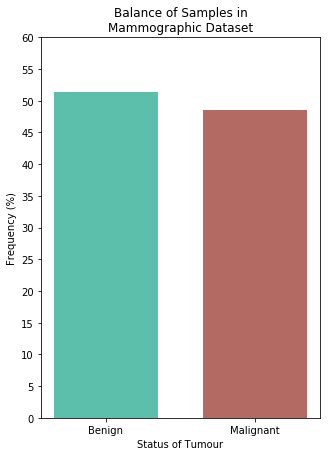

In [44]:
# Calculating lengths of subset dataframes with rows with benign
# or malignant observations.
malignant = len(mam_data.loc[mam_data['Severity'] == 1.0])
benign = len(mam_data.loc[mam_data['Severity'] == 0.0])

# Difference in samples between the datasets
difference = abs(malignant - benign)

total = len(mam_data)

per_malignant = \
    len(mam_data.loc[mam_data['Severity'] == 1.0])\
    / total * 100
per_benign = \
    len(mam_data.loc[mam_data['Severity'] == 0.0])\
    / total * 100

print('Difference in malignant and benign labelled data: %d\n' % difference)
print('Percentage of samples that are malignant: ' + str(per_malignant) +
      '\nPercentage of samples that are benign: ' + str(per_benign))

plt.bar(['Malignant', 'Benign'],
        [per_malignant, per_benign],
        0.7, color=['#922B21', '#17A589'],
        alpha=0.7)
plt.title('Balance of Samples in\nMammographic Dataset')
plt.ylim(0, 60)
plt.yticks(range(0, 61, 5))
plt.xlabel('Status of Tumour')
plt.ylabel('Frequency (%)')
fig = plt.gcf()
fig.set_size_inches(5, 7)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B50B6246A0>,
      dtype=object)

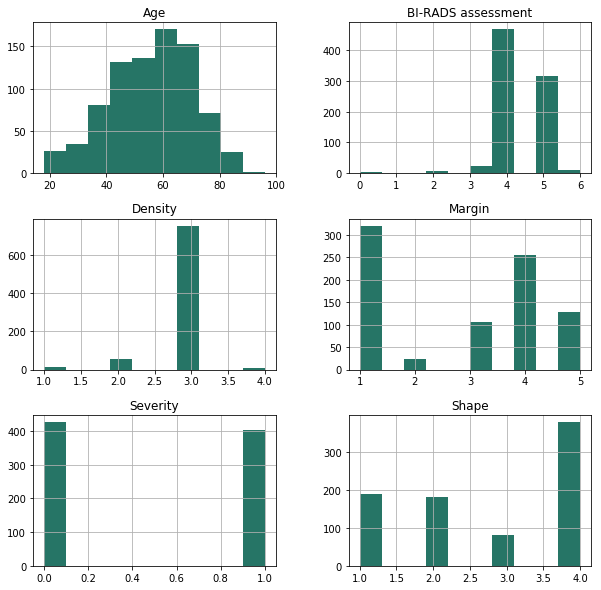

In [45]:
mam_data.hist(figsize=(10, 10),
              color='#0E6655',
              alpha=0.9,
              sharey=False,
              sharex=False)


BI-RADS assessment       AxesSubplot(0.125,0.536818;0.227941x0.343182)
Age                   AxesSubplot(0.398529,0.536818;0.227941x0.343182)
Shape                 AxesSubplot(0.672059,0.536818;0.227941x0.343182)
Margin                      AxesSubplot(0.125,0.125;0.227941x0.343182)
Density                  AxesSubplot(0.398529,0.125;0.227941x0.343182)
Severity                 AxesSubplot(0.672059,0.125;0.227941x0.343182)
dtype: object

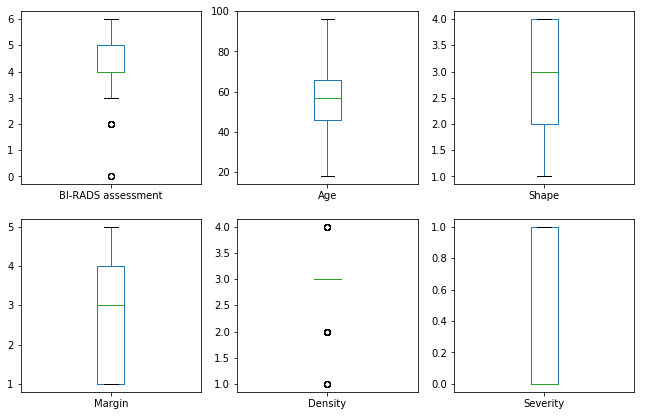

In [46]:
# Plot box-plots for the feature space and class
mam_data.plot(kind='box',
              subplots=True,
              layout=(2, 3),
              figsize=(11, 7))

In [47]:
# Test for normally distributed values of age
print('Age: ' + str(normaltest(mam_data['Age'].dropna().values)))
mam_data['Age'].mean()


Age: NormaltestResult(statistic=10.740851352619963, pvalue=0.0046521505784461615)


55.78192771084338

In [48]:
# percentage of density == 3
d = mam_data['Density'].dropna()
len(d.loc[d == 3])/len(d)


0.9096385542168675

BI-RADS assessment
LinregressResult(slope=0.38085022144060837, intercept=-1.164961742797432, rvalue=0.5240555056720301, pvalue=9.832889247510342e-60, stderr=0.02150999462187096)

Age
LinregressResult(slope=0.015516163685202776, intercept=-0.3799793523628956, rvalue=0.4552155350034975, pvalue=1.0753274918929513e-43, stderr=0.0010546980133646971)

Shape
LinregressResult(slope=0.22733611485401675, intercept=-0.14689046891316226, rvalue=0.5647627856640756, pvalue=4.207976459814182e-71, stderr=0.011544482215191935)

Margin
LinregressResult(slope=0.1833247037590428, intercept=-0.03019660635827104, rvalue=0.5744976369582521, pvalue=4.620207045799519e-74, stderr=0.009076942233098198)

Density
LinregressResult(slope=0.09782865234835962, intercept=0.20030682086381896, rvalue=0.0686505214138036, pvalue=0.04802415412881228, stderr=0.04940617714958588)



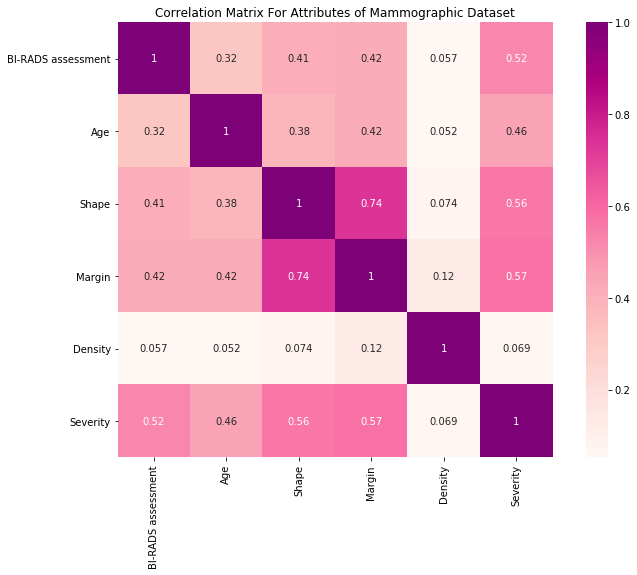

In [49]:
# All NaN values dropped as scipy.linregress does not exclude NaN values.
no_nan = mam_data.dropna(how='any', axis=0)
for i in no_nan.columns.values[:5]:
    print(i + '\n' +
          str(linregress(no_nan[i], no_nan['Severity'])) + '\n')

fig = plt.gcf()

mam_data_corr = mam_data.corr()
ax = sns.heatmap(mam_data_corr,
                 annot=True,
                 cmap='RdPu',
                 center=0.6,
                 cbar=True,
                 square=True,
                 linecolor='#2F4F4F')
plt.title('Correlation Matrix For Attributes of Mammographic Dataset')
fig.set_size_inches(12, 8)


---
## 6. Performance of The BI-RADS Assessment

For the purpose of evaluation, a new dataframe will be created from `mam_data`, containing only rows where BI-RADS is between 1 and 5. A BI-RADS score of 6 indicates that malignancy was previously known and a score of 0 represents an incomplete BI-RADS assessment. neither of these categories will be useful for evaluating this assessment.

In this dataset, only one patient scored less than 3 on the BI-RADS assessment (referral advised for scores of 3 and above) despite their tumour being malignant (~0.01%). There were also few true negatives reported (0.014%). As expected, the BI-RADS assessment over-reports potential malignant tumours, with 98.5% of all tumours being marked as potentially malignant and needing referal despite only 45.9% of all tumours actually being malignant. 

From this sample, 0.14% patients were successfully predicted as having benign tumours. However ~0.1% were informed that their tumour was unlikely to be malignant despite that not being the case. As this assessment leads to the recommendation of referral for almost all patients, I do not see the benefit of conducting it. Particularly as very few patients are given the peace of mind from a correct negative diagnosis at the cost of outliers not having their malignant tumour correctly diagnosed. 


In [50]:
# Creating new dataframe with only rows containing a BI-RADS score between 1 & 5.
BI_RADS_1_5 = BI_RADS.loc[~((BI_RADS['BI-RADS assessment'] > 5) |
             (BI_RADS['BI-RADS assessment'] < 1))]

# Removing all attributes, except for BI-RADS score and severity of tumour.
BI_RADS_1_5 = BI_RADS_1_5.iloc[:, [0, -1]]

# Remove all rows containng NaN as both columns are necessary.
BI_RADS_1_5.dropna(axis=0, how='any', inplace=True)

print(str(BI_RADS_1_5.head())
      + '\n...\n\n'
      + str(BI_RADS_1_5.tail()))

   BI-RADS assessment  Severity
0                 5.0         1
1                 4.0         1
2                 5.0         1
3                 4.0         0
4                 5.0         1
...

     BI-RADS assessment  Severity
956                 4.0         0
957                 4.0         1
958                 4.0         0
959                 5.0         1
960                 4.0         0


In [51]:
# Subsetting data BI_RADS into 4 dataframes containing false negatives,
# false positives, true negatives, and true positives respectively.
birads_fn = BI_RADS_1_5.loc[(BI_RADS_1_5['BI-RADS assessment'] < 3)
                            & (BI_RADS_1_5['Severity'] == 1)]

birads_fp = BI_RADS_1_5.loc[(BI_RADS_1_5['BI-RADS assessment'] >= 3)
                            & (BI_RADS_1_5['Severity'] == 0)]

birads_tp = BI_RADS_1_5.loc[(BI_RADS_1_5['BI-RADS assessment'] >= 3)
                            & (BI_RADS_1_5['Severity'] == 1)]

birads_tn = BI_RADS_1_5.loc[(BI_RADS_1_5['BI-RADS assessment'] < 3)
                            & (BI_RADS_1_5['Severity'] == 0)]

# Assigning lengths of these (i.e. numbers for these results) to variables.
# And calculating total number of observations with BI RADS assessments between
# 1 and 5.
tot = len(BI_RADS_1_5)
fn, fn_per = len(birads_fn), len(birads_fn)/tot
fp, fp_per = len(birads_fp), len(birads_fp)/tot
tn, tn_per = len(birads_tn), len(birads_tn)/tot
tp, tp_per = len(birads_tp), len(birads_tp)/tot
tot_p, tot_n = tp + fp, tn + fn

# Calculating accuracy by adding together percentage of
# true positives and negatives.
birads_accuracy = tn_per + tp_per

# Making a confusion matrix for the BI-RADS Assessment.
print('Confusion Matrix:\nTP = %d(%.3f)    '
      % (tp, tp_per, ) +
      'FN = %d(%.3f)\n\nFP = %d(%.3f)      TN = %d(%.3f)'
      % (fn, fn_per, fp, fp_per, tn, tn_per))

print('\nTotal Positive Reported: %d(%.3f)\nTotal Negative Reported: %d(%.3f)'
      % (tot_p, tot_p/tot, tot_n, tot_n/tot))

print('Total Actual Positive: %d(%.3f)\nTotal Actual Negative: %d(%.3f)\n'
      % (fn + tp, ((fn + tp)/tot), fp + tn, ((fp + tn)/tot)))

# Precision, recall & F1 for BI-RADS
BI_RADS_precision = tp / (tp + fp)
BI_RADS_recall = tp / (tp + fn)
BI_RADS_f1 = (2 * (BI_RADS_recall * BI_RADS_precision))\
             / (BI_RADS_recall + BI_RADS_precision)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f' %
      (BI_RADS_precision, BI_RADS_recall, BI_RADS_f1))


print('\nAccuracy: ' + str(birads_accuracy) + '\n')

# Assessing the accuracy of BI-RADS scores 4 and 5.
birads5 = BI_RADS_1_5.loc[BI_RADS_1_5['BI-RADS assessment'] == 5]
birads5_acc = np.mean(birads5['Severity'])

birads5_fp = len(birads5.loc[birads5['Severity'] == 0])
birads5_fp = birads5_fp/len(birads5)

print('Accuracy of BI-RADS highest score: %.3f' % birads5_acc)
print('False positive rate of BI-RADS highest score: %.3f' % birads5_fp)


Confusion Matrix:
TP = 432(0.458)    FN = 1(0.001)

FP = 497(0.527)      TN = 13(0.014)

Total Positive Reported: 929(0.985)
Total Negative Reported: 14(0.015)
Total Actual Positive: 433(0.459)
Total Actual Negative: 510(0.541)

Precision: 0.465
Recall: 0.998
F1: 0.634

Accuracy: 0.471898197242842

Accuracy of BI-RADS highest score: 0.884
False positive rate of BI-RADS highest score: 0.116


---
## 7. Feature Selection
The feature space for the training of classifiers in this investigation consisted of the following attributes from the mammographic masses dataset:

* Age of patient.
* Shape of the identified mass.
* Margin of the identified mass.
* Density of the mass.

The BI-RADS assessment will not be included as this is the current test, for which a calssifier produced will be compared to.

In [52]:
# Features(age, shape, margin and density)
feature_space = mam_data.iloc[:, 1:5].values
class_labels = mam_data.iloc[:, 5].values


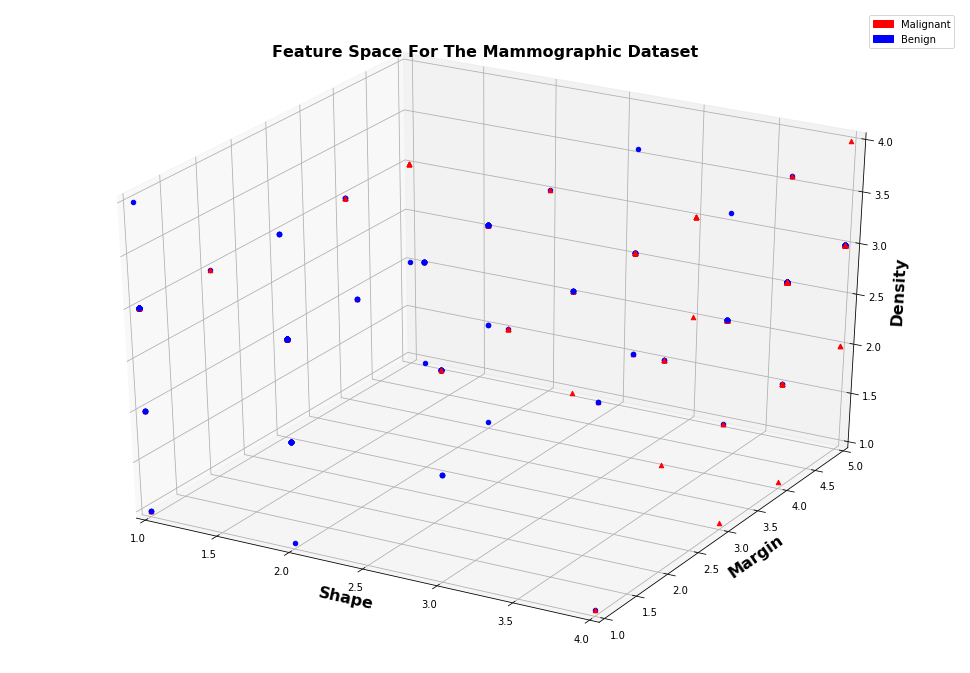

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

font_dict = {'weight': 'heavy',
             'size': 16}

for i in mam_data.values:
    if i[5] == 1:
        colour = 'r'
        shape = '^'
        ax.scatter(i[2], i[3], i[4],
                   c=colour, marker=shape)
    else:
        colour = 'b'
        shape = 'o'
        ax.scatter(i[2], i[3], i[4],
                   c=colour, marker=shape)

ax.set_xlabel('Shape', fontdict=font_dict)
ax.set_ylabel('Margin', fontdict=font_dict)
ax.set_zlabel('Density', fontdict=font_dict)
ax.set_xlim(1, 4)
ax.set_ylim(1, 5)
ax.set_zlim(1, 4)
plt.title('Feature Space For The Mammographic Dataset',
          fontdict=font_dict)
plt.gcf().set_size_inches(17,12)

malignant = mpatches.Patch(color='r',  label='Malignant')
benign = mpatches.Patch(color='b',  label='Benign')

plt.legend(handles=[malignant, benign])


---
## 8. Creating Training and Testing Datasets

A 80:20 split between training and testing data will be used.

The data will be split randomly from a seed. I have chosen today's date as the random seed to avoid bias. Furthermore, the use of a random seed allows for reproducibility, whereas using the functions default option, derrived from `numpy.random` would produce a non-reproducible split dataset.

In [54]:
print('Training sample: ' +
      str(len(train_test_split(mam_data, train_size=0.80,
                               random_state=20418)[0])))
print('Testing sample: ' +
      str(len(train_test_split(mam_data, train_size=0.80,
                               random_state=20418)[1])))

X_training, X_testing, y_training, y_testing = \
    train_test_split(feature_space, class_labels,
                     train_size=0.75, random_state=20418)

print('\nTraining X:\n' + str(X_training) + '\n')
print('Training y:\n' + str(y_training[0:30]) + '\n')
print('Testing X:\n' + str(X_testing) + '\n')
print('Testing y:\n' + str(y_testing[0:30]) + '\n')


Training sample: 664
Testing sample: 166

Training X:
[[58.  3.  4.  3.]
 [45.  2.  1.  3.]
 [65.  4.  5.  3.]
 ...
 [72.  4.  4.  3.]
 [71.  4.  5.  2.]
 [39.  1.  1.  3.]]

Training y:
[1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1]

Testing X:
[[59.  1.  1.  3.]
 [52.  4.  3.  3.]
 [53.  1.  1.  3.]
 [41.  1.  1.  3.]
 [64.  4.  4.  3.]
 [34.  2.  1.  3.]
 [62.  3.  1.  3.]
 [60.  4.  3.  3.]
 [65.  4.  5.  3.]
 [76.  4.  4.  3.]
 [72.  4.  3.  3.]
 [68.  4.  4.  3.]
 [52.  4.  4.  3.]
 [52.  4.  4.  3.]
 [57.  4.  3.  3.]
 [76.  4.  4.  3.]
 [67.  2.  1.  3.]
 [32.  1.  1.  3.]
 [74.  4.  3.  3.]
 [43.  2.  1.  3.]
 [40.  1.  4.  3.]
 [66.  1.  1.  3.]
 [61.  2.  4.  3.]
 [71.  4.  4.  3.]
 [19.  3.  1.  3.]
 [51.  4.  5.  3.]
 [55.  2.  1.  3.]
 [46.  1.  1.  3.]
 [42.  3.  4.  3.]
 [32.  1.  1.  3.]
 [36.  2.  1.  3.]
 [60.  4.  3.  3.]
 [69.  1.  5.  3.]
 [67.  4.  5.  3.]
 [64.  1.  1.  3.]
 [56.  1.  1.  3.]
 [77.  4.  4.  3.]
 [55.  4.  4.  3.]
 [31.  4.  4.  2.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


K-Fold cross validation will also be used for testing of classifiers.

In [55]:
kf = KFold(random_state=80418, n_splits=10, shuffle=True)
kf_split = kf.split(X_training, y_training)

for train, test in kf_split:
    print('%s - %s' % (train, test))

[  0   1   3   4   5   6   7   9  10  11  12  13  14  15  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  41  42  43  44  45  46  47  48  50  51  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  78  79  80
  81  82  85  87  88  89  90  91  92  93  98  99 100 101 102 103 104 105
 106 107 108 109 111 113 114 115 116 117 118 119 120 121 122 123 124 126
 127 128 129 130 131 133 134 135 136 137 138 139 140 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 159 160 161 162 163 164 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 188 190 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 229 230 231 232 233 234 235 236 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 27

---
## 9. Normalising Data

The support vector machine classifier requires features to be normalised (scaled to values between 0 and 1). The Random Forest classifier does not require this and will features, pre-normalisation.

In [56]:
mms = MinMaxScaler()

# For use with k-fold cross validation
X_normalised = \
    mms.fit_transform(feature_space)

X_training_normalised = \
    mms.fit_transform(X_training)
X_testing_normalised = \
    mms.fit_transform(X_testing)

print('Normalised Data:\n')
print('Mean: %.3f\nStdDev: %.3f\n\n' %
      (np.mean(X_normalised), np.std(X_normalised)) +
      'Training mean: %.3f\nTraining StdDev: %.3f\n\n' %
      (np.mean(X_training_normalised), np.std(X_training_normalised)) +
      'Testing mean: %.3f\nTesting StdDev: %.3f' %
      (np.mean(X_testing_normalised), np.std(X_testing_normalised)))


Normalised Data:

Mean: 0.543
StdDev: 0.315

Training mean: 0.537
Training StdDev: 0.315

Testing mean: 0.576
Testing StdDev: 0.315


---

---
## 10. Training Classifiers

As the attributes in the feature space are nominally categorised, the primary type of classifier used will be the decision tree classifier, specifically the Random Forests ensemble classifer. This will be contrasted against the support vector machine classifer.

As there are only two potential class labels, accuracy will be a useful performance metric. to calculate accuracy, the score function of scikit learn will be used. The following other testing metrics will be used:

* Confusion matrix
* Reciever Operator Characteristic (ROC) curve
* Area under ROC curve (AUC)
* F1 score

Hyper parameters will be optimised using a gridsearch to systematically produce the most accurate classifier.

---
## 10.1 Using a Support Vector Machine

The Radial basis function kernel will be used for this classifier. 

In [57]:
# Assigning features and class labels
X = X_training_normalised
y = y_training

print('\nSVC with RBF kernel')

# Values for the gridsearch
C_vals = [0.1, 1, 10, 50, 100]
gamma_vals = [0.01, 0.1, 1, 10]

grid = {'C': C_vals,
        'gamma': gamma_vals}
    
clf_svc = SVC(random_state=6042018,
              kernel='rbf',
              class_weight={0:1, 1:1})

# Applies the grid seach to the classifier and
# fits each model onto the data
gridsearch = GridSearchCV(clf_svc, grid, cv=10)
gridsearch.fit(X, y)
print(gridsearch.best_score_)
print(gridsearch.best_params_)



SVC with RBF kernel
0.8054662379421221
{'C': 50, 'gamma': 1}


In [58]:
# The SVM classifier with optimised hyperparameters
clf_svc = SVC(C=10,
              gamma=1,
              kernel='rbf',
              random_state=6042018,
              class_weight={0:1, 1:1},
              probability=True)

# 80:20 train, test split.
# Features and class labels for training assigned to 80% of the
# normalised data.
X = X_training_normalised  # Feature space
y = y_training  # Class labels
clf_svc.fit(X, y)  # Applying classifier to the train and test splits of data.

# Calculating the confusion matrix
X_test = X_testing_normalised
y_prediction = clf_svc.predict(X_test)
con_matrix = confusion_matrix(y_testing, y_prediction)

# Accuracy of the classifier
acc = clf_svc.score(X_testing_normalised, y_testing)

print('%s\n%s\nAccuracy score:  %.3f\n' % (clf_svc, '-' * 70, acc))
print(con_matrix)

# 10 fold cross-validation
kf = KFold(random_state=80418, n_splits=10, shuffle=True)

print('\n' + '-' * 70 + '\n10 Fold Cross-Validation\n')

# Blank list for calculating mean accuracy in 10-fold loop
accuracies = []

# Looping over each fold, testing accuracy, false positives
# and false negatives.
# calculating mean and standard deviation for accuracies of all folds
for i, (train_index, test_index) in enumerate(kf.split(X_training_normalised)):
    X_training_k, X_testing_k = X[train_index], X[test_index]
    y_training_k, y_testing_k = y[train_index], y[test_index]
    
    # Fitting model to the training data of fold i
    clf_svc.fit(X_training_k, y_training_k)
    # Calculating accuracy of fold against the in-sample testing split
    acc = clf_svc.score(X_testing_k, y_testing_k)
    accuracies.append(acc)
    
    y_prediction = clf_svc.predict(X_testing_k)
    con_matrix = confusion_matrix(y_testing_k, y_prediction)
    
    # Calculating rates of false positives and negatives
    fn = con_matrix[0, 1]
    fp = con_matrix[1, 0]
    fn_rate = (fn/np.sum(con_matrix)) * 100
    fp_rate = (fp/np.sum(con_matrix)) * 100
    

    print('Fold ' + str(i + 1))
    print('Accuracy score:   ' + str(acc))
    print('False Negatives: %f%%\nFalse Positives: %f%%\n' % (fn_rate, fp_rate))

print('\nMean Accuracy: %.3f%s+/- %.3f' % (np.mean(accuracies), ' ' * 10, np.std(accuracies)))


SVC(C=10, cache_size=200, class_weight={0: 1, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=6042018, shrinking=True,
  tol=0.001, verbose=False)
----------------------------------------------------------------------
Accuracy score:  0.812

[[72 27]
 [12 97]]

----------------------------------------------------------------------
10 Fold Cross-Validation

Fold 1
Accuracy score:   0.7936507936507936
False Negatives: 15.873016%
False Positives: 4.761905%

Fold 2
Accuracy score:   0.8412698412698413
False Negatives: 9.523810%
False Positives: 6.349206%

Fold 3
Accuracy score:   0.7580645161290323
False Negatives: 8.064516%
False Positives: 16.129032%

Fold 4
Accuracy score:   0.8709677419354839
False Negatives: 11.290323%
False Positives: 1.612903%

Fold 5
Accuracy score:   0.8225806451612904
False Negatives: 8.064516%
False Positives: 9.677419%

Fold 6
Accuracy score:   0.7258064516129032
False Negatives: 

---

## 10.2 Random Forest Classifier

In [59]:
X = X_training
y = y_training

depth = range(4, 9)
split = [2, 3, 4]
leaf_min = range(1, 5)
weighting = [{0: 1, 1: 1}, {0: 4, 1: 6},
             {0: 9, 1: 11}, {0: 4, 1: 5}]

grid = {'max_depth': depth,
        'min_samples_split': split,
        'min_samples_leaf': leaf_min,
        'class_weight' : weighting}

clf_rf = RandomForestClassifier(random_state=6042018,
                             n_estimators=20,
                             criterion='entropy',
                             max_features=4)

gridsearch = GridSearchCV(clf_rf, grid, cv=10)
gridsearch.fit(X, y)
gridsearch.best_params_
print(gridsearch.best_score_)
print(gridsearch.best_params_)


0.8038585209003215
{'class_weight': {0: 1, 1: 1}, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [60]:
clf_rf = RandomForestClassifier(random_state=6042018,
                             n_estimators=200,
                             criterion='entropy',
                             max_features=3,
                             max_depth=7,
                             min_samples_leaf=2,
                             min_samples_split=2,
                             class_weight={0: 9, 1: 11})

# 80:20 train, test split.
# Features and class labels for training assigned to 80% of the
# normalised data.
X = X_training  # Feature space
y = y_training  # Class labels
clf_rf.fit(X, y)  # Applying classifier to the train and test splits of data.

acc = clf_rf.score(X_testing, y_testing)
X_test = X_testing
y_prediction = clf_rf.predict(X_test)
con_matrix = confusion_matrix(y_testing, y_prediction)
fn_rate = (con_matrix[0, 1]/np.sum(con_matrix)) * 100

print('%s\n%s\nAccuracy score:  %.3f\n' % (clf_rf, '-' * 78, acc))
print('False Negatives: %f%%\n' % fn_rate)
print(con_matrix)

print('\nF1 Score: %.3f' %
      f1_score(y_testing, y_prediction))

# 10 fold cross-validation
kf = KFold(random_state=80418, n_splits=10, shuffle=True)

accuracies = []
fns= []
fps = []


# 10 fold cross-validation

print('\n' + '-' * 75 + '\n10 Fold Cross-Validation\n')
for i, (train_index, test_index) in enumerate(kf.split(X_training)):
    X_training_k, X_testing_k = X[train_index], X[test_index]
    y_training_k, y_testing_k = y[train_index], y[test_index]
    
    clf_rf.fit(X_training_k, y_training_k)
    
    acc = clf_rf.score(X_testing_k, y_testing_k)
    y_prediction = clf_rf.predict(X_testing_k)

    con_matrix = confusion_matrix(y_testing_k, y_prediction)
    fn = con_matrix[0, 1]
    fp = con_matrix[1, 0]
    fn_rate = (fn/np.sum(con_matrix)) * 100
    fp_rate = (fp/np.sum(con_matrix)) * 100

    accuracies.append(acc)

    print('Fold ' + str(i + 1))
    print('Accuracy score:   ' + str(acc))
    print('False Negatives: %f%%\nFalse Positives: %f%%\n' % (fn_rate, fp_rate))

print('\nMean Accuracy: %.3f%s+/- %.3f' % (np.mean(accuracies), ' ' * 10, np.std(accuracies)))


RandomForestClassifier(bootstrap=True, class_weight={0: 9, 1: 11},
            criterion='entropy', max_depth=7, max_features=3,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False,
            random_state=6042018, verbose=0, warm_start=False)
------------------------------------------------------------------------------
Accuracy score:  0.808

False Negatives: 10.576923%

[[77 22]
 [18 91]]

F1 Score: 0.820

---------------------------------------------------------------------------
10 Fold Cross-Validation

Fold 1
Accuracy score:   0.7619047619047619
False Negatives: 19.047619%
False Positives: 4.761905%

Fold 2
Accuracy score:   0.8095238095238095
False Negatives: 9.523810%
False Positives: 9.523810%

Fold 3
Accuracy score:   0.7903225806451613
False Negatives: 6.451613%
False Positives: 14.516129%

F

---

## 11. Further Evaluation of Classifiers Using Out of Sample Data

Models tested on out-of-sample data. Reciever opperating characteristics plotted. In addition, area under curve (AUC), precision, recall and F1 calculated for each classifier. Values calculated as mean of each fold, with standard deviation.

In [61]:
# Accessing the probability predictions of the two classifiers
svc_pp = clf_svc.predict_proba(X_testing_normalised)
rf_pp = clf_rf.predict_proba(X_testing)


SVM
Mean AUC: 0.865           +/- 0.00728
Mean Precision Score: 0.811           +/- 0.013
Mean Recall Score: 0.913           +/- 0.009
Mean F1 Score: 0.859           +/- 0.006

Random Forest
Mean AUC: 0.940           +/- 0.00438
Mean Precision Score: 0.823           +/- 0.015
Mean Recall Score: 0.943           +/- 0.012
Mean F1 Score: 0.879           +/- 0.011



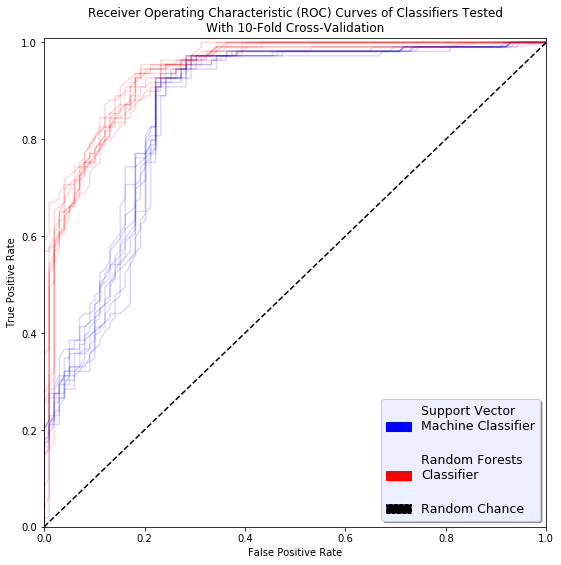

In [62]:
# Creating lists of the classifiers, their names and colours
# they will be plotted with
clf_list = [clf_svc, clf_rf]
clf_names = ['SVM', 'Random Forest']
colours_list = ['b', 'r']

# 10 fold cross validation
kf = KFold(random_state=80418, n_splits=10, shuffle=True)

# looping through each classifier
for classifier, name, colour in zip(clf_list, clf_names, colours_list):
    F1s = []
    auc_metric_list = []
    precisions = []
    recalls = []
    # If the classifier is the SVM, use the scaled features
    if classifier == clf_list[0]:
        X, y = X_testing_normalised, y_testing
        # Create and loop through 10 folds
        # Calculate values for AUC, precision, recall and F1. Append
        # these values to their respective lists to calculate mean
        # and standard deviation.
        for train_index, test_index in kf.split(X, y):
            X_training_k = X[train_index]
            y_training_k = y[train_index]

            classifier.fit(X_training_k, y_training_k)
            
            y_prediction = classifier.predict(X_testing_normalised)
            precision = precision_score(y_testing, y_prediction)
            recall = recall_score(y_testing, y_prediction)
            F1 = f1_score(y_testing, y_prediction)
            F1s.append(F1)
            precisions.append(precision)
            recalls.append(recall)
            
            pp = classifier.predict_proba(X_testing_normalised)[:, 1]
            fpr, tpr, _ = roc_curve(y_testing, pp)
            auc_metric = auc(fpr, tpr)
            auc_metric_list.append(auc_metric)
            # Plot the ROC for each fold with its corresponding colour
            plt.plot(fpr, tpr, c=colour, alpha=0.15)
    # If the classifier is the RF, use the unscaled features
    # Same as previous loop
    else:
        X, y = X_testing, y_testing
        for train_index, test_index in kf.split(X, y):
            X_training_k = X[train_index]
            y_training_k = y[train_index]

            classifier.fit(X_training_k, y_training_k)
            
            y_prediction = classifier.predict(X_testing)
            precision = precision_score(y_testing, y_prediction)
            recall = recall_score(y_testing, y_prediction)

            F1 = f1_score(y_testing, y_prediction)
            F1s.append(F1)
            precisions.append(precision)
            recalls.append(recall)

            pp = classifier.predict_proba(X_testing)[:, 1]
            fpr, tpr, _ = roc_curve(y_testing, pp)
            auc_metric = auc(fpr, tpr)
            auc_metric_list.append(auc_metric)
            plt.plot(fpr, tpr, c=colour, alpha=0.15)
    # Print mean and standard deviation for each metric
    clf_auc = np.mean(auc_metric_list)
    clf_auc_std = np.std(auc_metric_list)
    print('%s\nMean AUC: %.3f%s +/- %.5f' %
          (name, clf_auc, ' ' * 10, clf_auc_std))
    print('Mean Precision Score: %.3f%s +/- %.3f' %
          (np.mean(precisions), ' ' * 10, np.std(precisions)))
    print('Mean Recall Score: %.3f%s +/- %.3f' %
          (np.mean(recalls), ' ' * 10, np.std(recalls)))
    print('Mean F1 Score: %.3f%s +/- %.3f\n' %
          (np.mean(F1s), ' ' * 10, np.std(F1s)))
    
# Settings for plot
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(9, 9)
plt.plot([0, 1], [0, 1], c='k', ls='--')
plt.xlim(0, 1)
plt.ylim(0, 1.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) ' +
          'Curves of Classifiers Tested\nWith 10-' +
          'Fold Cross-Validation')

# Custom lables for legend
svm_lab = mpatches.Patch(color='b',
                         label='Support Vector\nMachine Classifier\n')
rf_lab = mpatches.Patch(color='r',
                        label='Random Forests\nClassifier\n')
chance_lab = mpatches.Patch(color='k', linestyle='--',
                            label='Random Chance')

plt.legend(handles=[svm_lab, rf_lab, chance_lab],
           loc='lower right',
           fontsize=12.5,
           fancybox=True,
           shadow=True,
           facecolor='#ECEFFF')


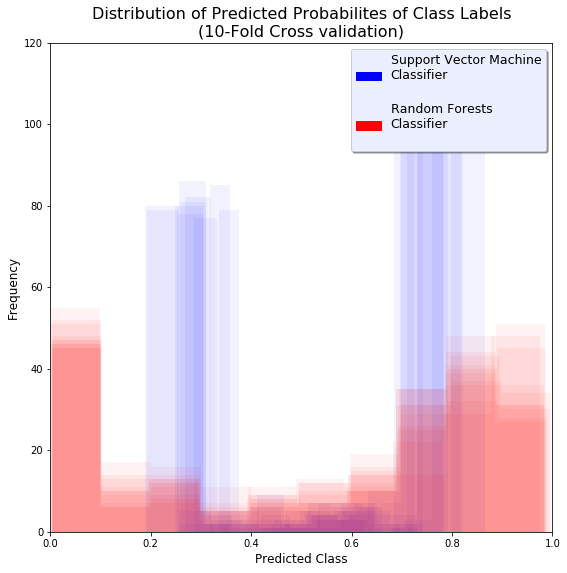

In [63]:
clf_list = [clf_svc, clf_rf]
clf_names = ['Support Vector Machine',
             'Random Forest']
colours_list = ['b', 'r']

kf = KFold(random_state=80418, n_splits=10, shuffle=True)

for classifier, name, colour in zip(clf_list, clf_names, colours_list):
    X, y = X_testing, y_testing
    for train_index, test_index in kf.split(X, y):
        X_training_k = X[train_index]
        y_training_k = y[train_index]

        classifier.fit(X_training_k, y_training_k)
        pp = classifier.predict_proba(X_testing)[:, 1]
            
        plt.hist(pp, color=colour, alpha=0.05)

fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(9, 9)

plt.title('Distribution of Predicted Probabilites of Class Labels' +
          '\n(10-Fold Cross validation)',
          fontsize=16)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 120)

# Custom lables for legend
dt_lab = mpatches.Patch(color='b',
                        label='Support Vector Machine\nClassifier\n')
rf_lab = mpatches.Patch(color='r',
                        label='Random Forests\nClassifier\n')

plt.legend(handles=[dt_lab, rf_lab],
           loc='upper right',
           fontsize=12.5,
           fancybox=True,
           shadow=True,
           facecolor='#ECEFFF')


---


## 12. Testing Different Hyperparameters For The Two Classifiers 

---

## 12.1 Testing Different Hyperparameters For The SVM Classifier

In [64]:
# Assigning SVM classifiers for each different penalty perameter
clf_svc1 = SVC(C=0.1,
              gamma=1,
              kernel='rbf',
              random_state=6042018,
              class_weight={0:1, 1:1},
              probability=True)

clf_svc2 = SVC(C=1,
              gamma=1,
              kernel='rbf',
              random_state=6042018,
              class_weight={0:1, 1:1},
              probability=True)

clf_svc3 = SVC(C=10,
              gamma=1,
              kernel='rbf',
              random_state=6042018,
              class_weight={0:1, 1:1},
              probability=True)

clf_svc4 = SVC(C=50,
              gamma=1,
              kernel='rbf',
              random_state=6042018,
              class_weight={0:1, 1:1},
              probability=True)

clf_svc5 = SVC(C=100,
              gamma=1,
              kernel='rbf',
              random_state=6042018,
              class_weight={0:1, 1:1},
              probability=True)


C=0.1
Mean AUC: 0.810           +/- 0.00194
Mean Precision Score: 0.759           +/- 0.001
Mean Recall Score: 0.901           +/- 0.006
Mean F1 Score: 0.824           +/- 0.002

C=1
Mean AUC: 0.841           +/- 0.00323
Mean Precision Score: 0.761           +/- 0.006
Mean Recall Score: 0.916           +/- 0.006
Mean F1 Score: 0.831           +/- 0.003

C=10
Mean AUC: 0.865           +/- 0.00728
Mean Precision Score: 0.811           +/- 0.013
Mean Recall Score: 0.913           +/- 0.009
Mean F1 Score: 0.859           +/- 0.006

C=50
Mean AUC: 0.896           +/- 0.01190
Mean Precision Score: 0.814           +/- 0.007
Mean Recall Score: 0.915           +/- 0.007
Mean F1 Score: 0.861           +/- 0.004

C=100
Mean AUC: 0.903           +/- 0.00724
Mean Precision Score: 0.812           +/- 0.011
Mean Recall Score: 0.917           +/- 0.010
Mean F1 Score: 0.861           +/- 0.004



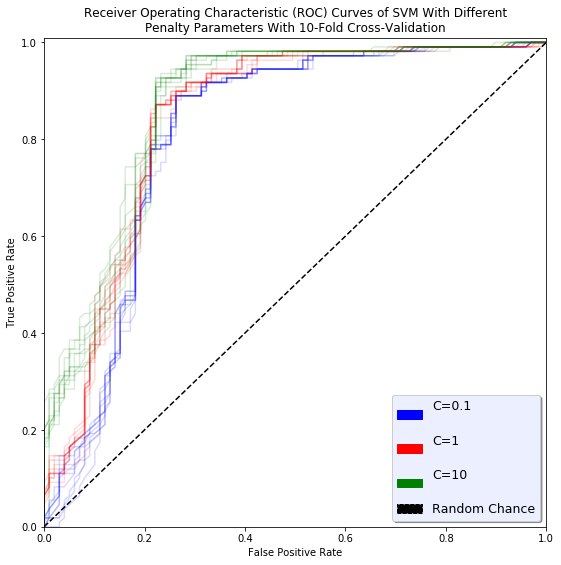

In [65]:
# Looping through each C value for the SVM classifier, calculating
# performance metrics and plotting ROC curves
clf_list = [clf_svc1, clf_svc2, clf_svc3, clf_svc4, clf_svc5]
clf_names = ['C=0.1', 'C=1', 'C=10', 'C=50', 'C=100']
colours_list = ['b', 'r', 'g', '', '']

kf = KFold(random_state=80418, n_splits=10, shuffle=True)

for classifier, name, colour in zip(clf_list, clf_names, colours_list):
    F1s = []
    auc_metric_list = []
    precisions = []
    recalls = []
    X, y = X_testing_normalised, y_testing
    for train_index, test_index in kf.split(X, y):
        X_training_k = X[train_index]
        y_training_k = y[train_index]

        classifier.fit(X_training_k, y_training_k)
            
        y_prediction = classifier.predict(X_testing_normalised)
        precision = precision_score(y_testing, y_prediction)
        recall = recall_score(y_testing, y_prediction)
        F1 = f1_score(y_testing, y_prediction)
        F1s.append(F1)
        precisions.append(precision)
        recalls.append(recall)

        pp = classifier.predict_proba(X_testing_normalised)[:, 1]
        fpr, tpr, _ = roc_curve(y_testing, pp)
        auc_metric = auc(fpr, tpr)
        auc_metric_list.append(auc_metric)
        if classifier in clf_list[:3]:
            plt.plot(fpr, tpr, c=colour, alpha=0.15)
    
    clf_auc = np.mean(auc_metric_list)
    clf_auc_std = np.std(auc_metric_list)
    print('%s\nMean AUC: %.3f%s +/- %.5f' %
          (name, clf_auc, ' ' * 10, clf_auc_std))
    print('Mean Precision Score: %.3f%s +/- %.3f' %
          (np.mean(precisions), ' ' * 10, np.std(precisions)))
    print('Mean Recall Score: %.3f%s +/- %.3f' %
          (np.mean(recalls), ' ' * 10, np.std(recalls)))
    print('Mean F1 Score: %.3f%s +/- %.3f\n' %
          (np.mean(F1s), ' ' * 10, np.std(F1s)))
    

fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(9, 9)
plt.plot([0, 1], [0, 1], c='k', ls='--')
plt.xlim(0, 1)
plt.ylim(0, 1.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) ' +
          'Curves of SVM With Different\nPenalty Parameters With 10-' +
          'Fold Cross-Validation')

# Custom lables for legend
svm1_lab = mpatches.Patch(color='b',
                         label='C=0.1\n')
svm2_lab = mpatches.Patch(color='r',
                        label='C=1\n')
svm3_lab = mpatches.Patch(color='g',
                        label='C=10\n')
chance_lab = mpatches.Patch(color='k', linestyle='--',
                            label='Random Chance')

plt.legend(handles=[svm1_lab, svm2_lab, svm3_lab, chance_lab],
           loc='lower right',
           fontsize=12.5,
           fancybox=True,
           shadow=True,
           facecolor='#ECEFFF')


---

## 12.2 Testing Different Hyperparameters For The Random Forests Classifier

In [66]:
clf_rf1 = RandomForestClassifier(random_state=6042018,
                                 n_estimators=200,
                                 criterion='entropy',
                                 max_features=3,
                                 max_depth=5,
                                 min_samples_leaf=2,
                                 min_samples_split=2,
                                 class_weight={0: 9, 1: 11})

clf_rf2 = RandomForestClassifier(random_state=6042018,
                                 n_estimators=200,
                                 criterion='entropy',
                                 max_features=3,
                                 max_depth=7,
                                 min_samples_leaf=2,
                                 min_samples_split=2,
                                 class_weight={0: 9, 1: 11})

clf_rf3 = RandomForestClassifier(random_state=6042018,
                                 n_estimators=200,
                                 criterion='entropy',
                                 max_features=3,
                                 max_depth=9,
                                 min_samples_leaf=2,
                                 min_samples_split=2,
                                 class_weight={0: 9, 1: 11})

clf_rf4 = RandomForestClassifier(random_state=6042018,
                                 n_estimators=200,
                                 criterion='entropy',
                                 max_features=3,
                                 max_depth=11,
                                 min_samples_leaf=2,
                                 min_samples_split=2,
                                 class_weight={0: 9, 1: 11})

clf_rf5 = RandomForestClassifier(random_state=6042018,
                                 n_estimators=200,
                                 criterion='entropy',
                                 max_features=3,
                                 max_depth=20,
                                 min_samples_leaf=2,
                                 min_samples_split=2,
                                 class_weight={0: 9, 1: 11})

clf_rf6 = RandomForestClassifier(random_state=6042018,
                                 n_estimators=200,
                                 criterion='entropy',
                                 max_features=3,
                                 max_depth=100,
                                 min_samples_leaf=2,
                                 min_samples_split=2,
                                 class_weight={0: 9, 1: 11})


Max Depth = 5
Mean AUC: 0.926           +/- 0.00319
Mean Precision Score: 0.795           +/- 0.009
Mean Recall Score: 0.943           +/- 0.011
Mean F1 Score: 0.863           +/- 0.007

Max Depth = 7
Mean AUC: 0.940           +/- 0.00438
Mean Precision Score: 0.823           +/- 0.015
Mean Recall Score: 0.943           +/- 0.012
Mean F1 Score: 0.879           +/- 0.011

Max Depth = 9
Mean AUC: 0.945           +/- 0.00446
Mean Precision Score: 0.833           +/- 0.013
Mean Recall Score: 0.939           +/- 0.014
Mean F1 Score: 0.883           +/- 0.010

Max Depth = 11
Mean AUC: 0.947           +/- 0.00458
Mean Precision Score: 0.840           +/- 0.012
Mean Recall Score: 0.935           +/- 0.014
Mean F1 Score: 0.885           +/- 0.009

Max Depth = 20
Mean AUC: 0.947           +/- 0.00472
Mean Precision Score: 0.839           +/- 0.013
Mean Recall Score: 0.935           +/- 0.014
Mean F1 Score: 0.884           +/- 0.009

Max Depth = 100
Mean AUC: 0.947           +/- 0.00472
Mean Prec

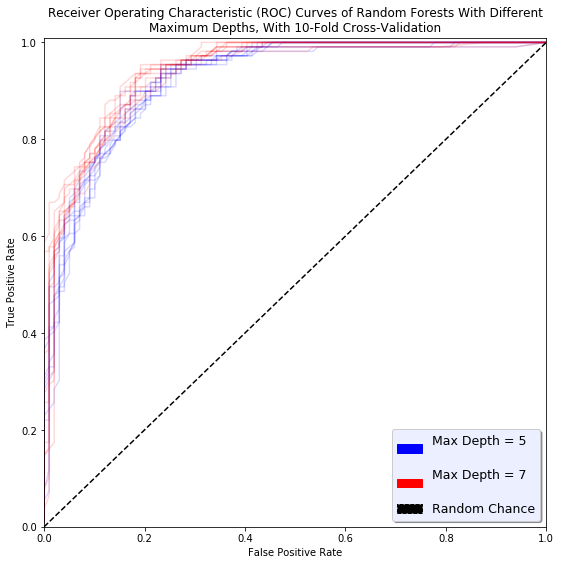

In [67]:
clf_list = [clf_rf1, clf_rf2, clf_rf3, clf_rf4, clf_rf5, clf_rf6]
clf_names = ['Max Depth = 5', 'Max Depth = 7',
             'Max Depth = 9', 'Max Depth = 11',
             'Max Depth = 20', 'Max Depth = 100']
colours_list = ['b', 'r', '', '', '', '']

kf = KFold(random_state=80418, n_splits=10, shuffle=True)

for classifier, name, colour in zip(clf_list, clf_names, colours_list):
    F1s = []
    auc_metric_list = []
    precisions = []
    recalls = []
    X, y = X_testing, y_testing
    for train_index, test_index in kf.split(X, y):
        X_training_k = X[train_index]
        y_training_k = y[train_index]

        classifier.fit(X_training_k, y_training_k)

        y_prediction = classifier.predict(X_testing)
        precision = precision_score(y_testing, y_prediction)
        recall = recall_score(y_testing, y_prediction)

        F1 = f1_score(y_testing, y_prediction)
        F1s.append(F1)
        precisions.append(precision)
        recalls.append(recall)

        pp = classifier.predict_proba(X_testing)[:, 1]
        fpr, tpr, _ = roc_curve(y_testing, pp)
        auc_metric = auc(fpr, tpr)
        auc_metric_list.append(auc_metric)
        if classifier in clf_list[:2]:
            plt.plot(fpr, tpr, c=colour, alpha=0.15)
    clf_auc = np.mean(auc_metric_list)
    clf_auc_std = np.std(auc_metric_list)
    print('%s\nMean AUC: %.3f%s +/- %.5f' %
          (name, clf_auc, ' ' * 10, clf_auc_std))
    print('Mean Precision Score: %.3f%s +/- %.3f' %
          (np.mean(precisions), ' ' * 10, np.std(precisions)))
    print('Mean Recall Score: %.3f%s +/- %.3f' %
          (np.mean(recalls), ' ' * 10, np.std(recalls)))
    print('Mean F1 Score: %.3f%s +/- %.3f\n' %
          (np.mean(F1s), ' ' * 10, np.std(F1s)))
    

fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(9, 9)
plt.plot([0, 1], [0, 1], c='k', ls='--')
plt.xlim(0, 1)
plt.ylim(0, 1.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) ' +
          'Curves of Random Forests With Different\nMaximum Depths, With 10-' +
          'Fold Cross-Validation')

# Custom lables for legend
rf1_lab = mpatches.Patch(color='b',
                         label='Max Depth = 5\n')
rf2_lab = mpatches.Patch(color='r',
                         label='Max Depth = 7\n')
chance_lab = mpatches.Patch(color='k', linestyle='--',
                            label='Random Chance')

plt.legend(handles=[rf1_lab, rf2_lab, chance_lab],
           loc='lower right',
           fontsize=12.5,
           fancybox=True,
           shadow=True,
           facecolor='#ECEFFF')


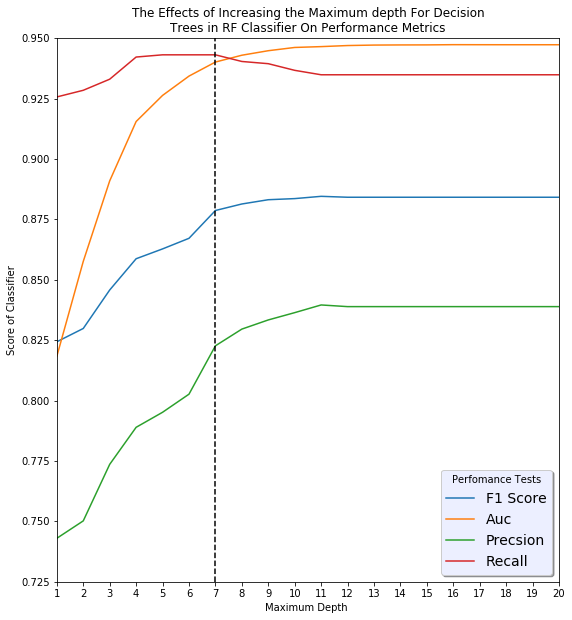

In [68]:
# Assigning range of values to test for maximum depth hyperparameter
plot_range = np.arange(1, 21, 1)

f1_list = []
auc_list = []
precision_list = []
recall_list = []
# Looping through range, calculating mean performance metrics of all
# folds, for each max depth.
# Mean performance metrics added to lists and plotted
for i in plot_range:
    clf_rf_depth = RandomForestClassifier(random_state=6042018,
                                           n_estimators=200,
                                           criterion='entropy',
                                           max_features=3,
                                           max_depth=i,
                                           min_samples_leaf=2,
                                           min_samples_split=2,
                                           class_weight={0: 9, 1: 11})

    
    F1s = []
    auc_metrics = []
    precisions = []
    recalls = []
    X, y = X_testing, y_testing
    for train_index, test_index in kf.split(X, y):
        X_training_k = X[train_index]
        y_training_k = y[train_index]

        clf_rf_depth.fit(X_training_k, y_training_k)

        y_prediction = clf_rf_depth.predict(X_testing)
        precision = precision_score(y_testing, y_prediction)
        recall = recall_score(y_testing, y_prediction)

        F1 = f1_score(y_testing, y_prediction)
        F1s.append(F1)
        precisions.append(precision)
        recalls.append(recall)

        pp = clf_rf_depth.predict_proba(X_testing)[:, 1]
        fpr, tpr, _ = roc_curve(y_testing, pp)
        auc_metric = auc(fpr, tpr)
        auc_metrics.append(auc_metric)

    f1_list.append(np.mean(F1s))
    auc_list.append(np.mean(auc_metrics))
    precision_list.append(np.mean(precisions))
    recall_list.append(np.mean(recalls))

metrics = [f1_list, auc_list, precision_list, recall_list]
labels = ['F1 Score', 'Auc', 'Precsion', 'Recall']

fig = plt.gcf()

for i, j in zip(metrics, labels):
    plt.plot(plot_range, i, label=j)

# Plots line at point of chosen hyperparameter
plt.axvline(x=7, ls='--', c='k')

plt.ylim(0.725, 0.95)
plt.xlim(1, 20)
plt.xticks(plot_range)
plt.xlabel('Maximum Depth ')
plt.ylabel('Score of Classifier')
plt.title('The Effects of Increasing the Maximum depth For Decision' +
          '\nTrees in RF Classifier On Performance Metrics')
plt.legend(title='Perfomance Tests',
           loc='lower right',
           fontsize=14,
           fancybox=True,
           shadow=True,
           facecolor='#ECEFFF')
fig.set_size_inches(9,10)
